# Importing NN modules and data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import sys
sys.path.insert(0,"/content/drive/My Drive/Colab Notebooks/NeuralNetwork")

In [4]:
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import os
import torch.optim as optim


import numpy as np
import random
import copy
import pickle
import pandas as pd
import time

from library_model import layers as lay
from library_model import model_building as mb
from library_model import model_training as mt
from data import data_loading as dt
from data import text as txt

# Process Data

In [5]:
from torchvision import datasets, transforms
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Lambda

In [47]:
train_data = datasets.FashionMNIST(root = "data" , train = True, download = True, transform = ToTensor(), target_transform= Lambda( lambda y: torch.zeros(10, dtype= torch.float).scatter_(0,torch.tensor(y),value = 1)))
test_data = datasets.FashionMNIST(root = "data" , train = False, download = True, transform = ToTensor(), target_transform= Lambda( lambda y: torch.zeros(10, dtype= torch.float).scatter_(0,torch.tensor(y),value = 1)))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [48]:
d = dt.Data()
d.train_dataloader = DataLoader( dataset= train_data, batch_size = 64, shuffle = True)
d.test_dataloader = DataLoader( dataset= test_data, batch_size = 64, shuffle = True)

In [49]:
x1, y1 = (next(iter(d.train_dataloader)))
x1.size(), y1.size()

(torch.Size([64, 1, 28, 28]), torch.Size([64, 10]))

In [52]:
batch_num = len(d.train_dataloader)
num_epochs = 5
batch_num

938

# Define Network State

In [58]:
state = lay.Network_state()
p = state.parameters
tr = state.training
p.dropout = 0.2
p.convlayers = [{"filter_dim" : int(5), "in_features": int(1), "out_features": int(10)}, {"filter_dim": int(5), "in_features": int(10), "out_features" : int(10)}]
p.linearlayers = [{"dim_in" : int(10*(4**2)), "dim_hid" : int(100), "bias_is_true" : True , "relu_is_true" : True}, {"dim_in" : int(100), "dim_hid" : int(10), "bias_is_true" : True, "relu_is_true" : False}]
tr.lr = 1.
tr.batch_size = 64
tr.optimizer = "sgd"
tr.schedule = mb.learning_rate_cosine(1., batch_num*num_epochs, 0.1)

# Construct Model

In [60]:
model = mb.Convolutional(state).to(state.device)

In [61]:
opt, scheduler = mb.get_optimizer(state, model)
criterion = nn.CrossEntropyLoss().to(state.device)

# Train Model

Epoch training and network evaluation functions

In [74]:
train_fashion = mt.CNN_training(data = d, state = state, model = model, opt = opt, scheduler = scheduler)

In [75]:
train_fashion(num_epochs)

Batch 200 | lr = 0.96 | time = 0.0665 | train loss 0.46
Batch 400 | lr = 0.91 | time = 0.0587 | train loss 0.47
Batch 600 | lr = 0.86 | time = 0.0615 | train loss 0.40
Batch 800 | lr = 0.80 | time = 0.0807 | train loss 0.38
Epoch: 0 | time: 0.04 -- test loss = 0.43 -- accuracy = 0.80



KeyboardInterrupt: ignored

# Cifar 10 - Loading dataset

In [42]:
transform2 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size2 = 4
train_data2 = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform2)

test_data2 = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform2)

Files already downloaded and verified
Files already downloaded and verified


In [43]:
d2 = dt.Data()
d2.train_dataloader = DataLoader(train_data2, batch_size=batch_size2,
                                          shuffle=True)
d2.test_dataloader = DataLoader(test_data2, batch_size=batch_size2,
                                          shuffle=True)

In [44]:
x,y = next(iter(d2.train_dataloader))

In [45]:
def imshow(*images):
  plt.figure(figsize= (9,5))
  for k,img in enumerate(images): 
    plt.subplot(len(images)//4+1,4,k+1)
    npimg= img.numpy()
    npimg = (npimg/2 + 0.5).transpose(1,2,0)
    plt.imshow(npimg)
    plt.axis("off")

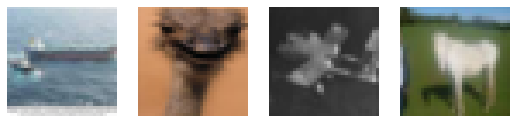

In [46]:
imshow(x[0], x[1], x[2], x[3])

In [ ]:
state2 = lay.Network_state()
p2 = state2.parameters
tr2 = state2.training
p2.dropout = 0.2
p2.convlayers = [{"filter_dim" : int(5), "in_features": int(3), "out_features": int(10)}, {"filter_dim": int(5), "in_features": int(10), "out_features" : int(10)}]
p2.linearlayers = [{"dim_in" : int(10*(4**2)), "dim_hid" : int(100), "bias_is_true" : True , "relu_is_true" : True}, {"dim_in" : int(100), "dim_hid" : int(10), "bias_is_true" : True, "relu_is_true" : False}]
tr2.lr = 1.
tr2.batch_size = 4
tr2.optimizer = "sgd"
tr2.schedule = mb.learning_rate_step(1., 1.1, 1)